In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
import statsmodels.api as sm
warnings.simplefilter("ignore")

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm, datasets

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE

from fonctions import *

In [2]:
df_billet=pd.read_csv("billets.csv", delimiter = ";")
df_billet_save = df_billet.copy()

## 1- Analyse des données
Vérification des données (analyses univariées et bivariées) et description.

In [3]:
df_billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
df_billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Plusieurs valeur null dans margin low

### REGRESSION LINEAIRE MULTIPLE POUR REMPLACEMENT DES VALEURS MANQUANTES

In [5]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df_billet).fit()
print(reg_multi.summary())

#liste des valeurs manquantes de la dataframe
a_prevoir_ = df_billet[~df_billet.index.isin(df_billet.dropna().index)]
#On utilise la regression lineaire multiple creer juste avant.
margin_low_prev = reg_multi.predict(a_prevoir_)
#boucle qui premet d'inscrire les nouvelles valeurs à la place des valeurs manquantes
for i in margin_low_prev.index:
    df_billet['margin_low'][i] = margin_low_prev[i]
    
print(df_billet)

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 29 Mar 2023   Prob (F-statistic):          2.60e-202
Time:                        19:02:14   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

In [6]:
df_billet.isna().mean()

is_genuine      0.0
diagonal        0.0
height_left     0.0
height_right    0.0
margin_low      0.0
margin_up       0.0
length          0.0
dtype: float64

In [7]:
df_billet['is_genuine'].unique()

array([ True, False])

<Axes: title={'center': 'diagonal'}, xlabel='is_genuine'>

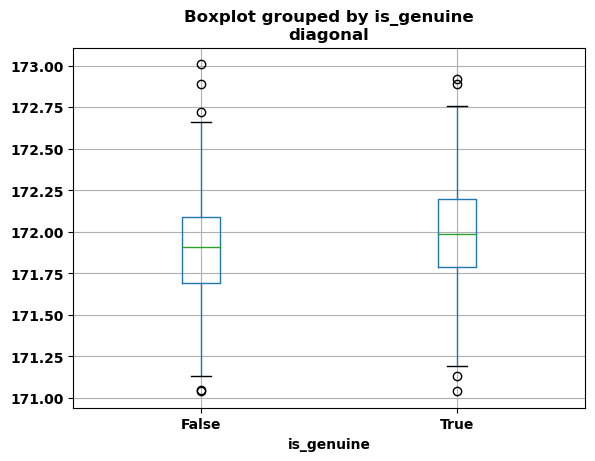

In [8]:
df_billet.boxplot(column='diagonal',by='is_genuine')

<Axes: title={'center': 'height_left'}, xlabel='is_genuine'>

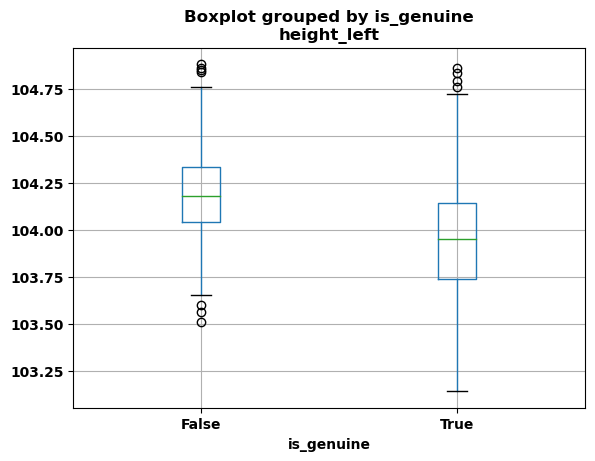

In [9]:
df_billet.boxplot(column='height_left',by='is_genuine')

<Axes: title={'center': 'height_right'}, xlabel='is_genuine'>

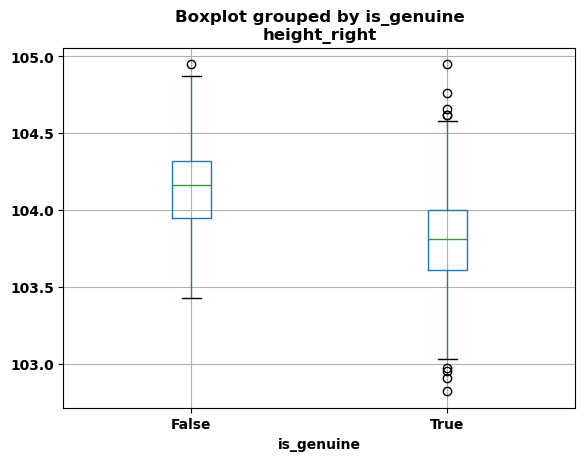

In [10]:
df_billet.boxplot(column='height_right',by='is_genuine')

<Axes: title={'center': 'margin_low'}, xlabel='is_genuine'>

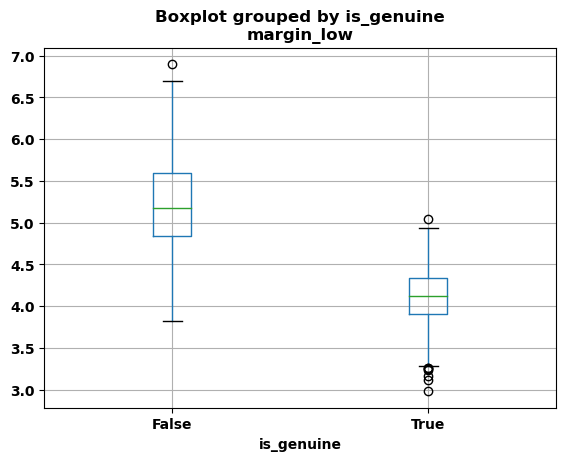

In [11]:
df_billet.boxplot(column='margin_low',by='is_genuine')

Marge basse plus longue chez les faux billets

<Axes: title={'center': 'margin_up'}, xlabel='is_genuine'>

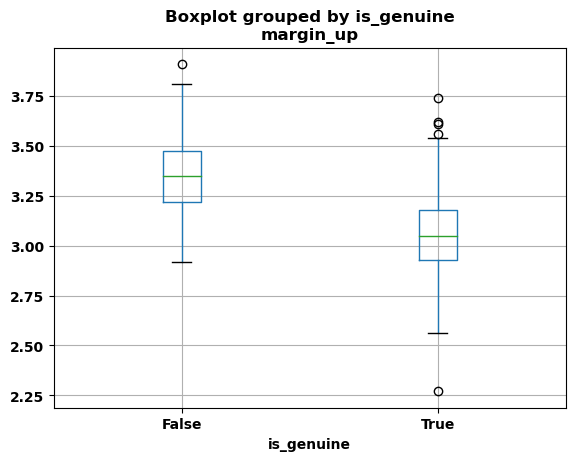

In [12]:
df_billet.boxplot(column='margin_up',by='is_genuine')

<Axes: title={'center': 'length'}, xlabel='is_genuine'>

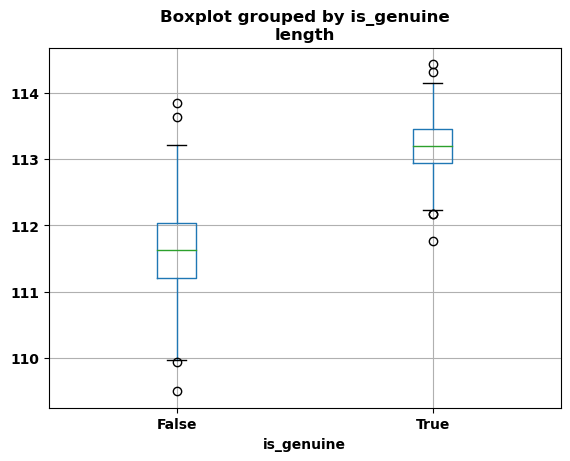

In [13]:
df_billet.boxplot(column='length',by='is_genuine')

Les vrais billets sont plus long que les faux.

### ANALYSE DE CORRELATION

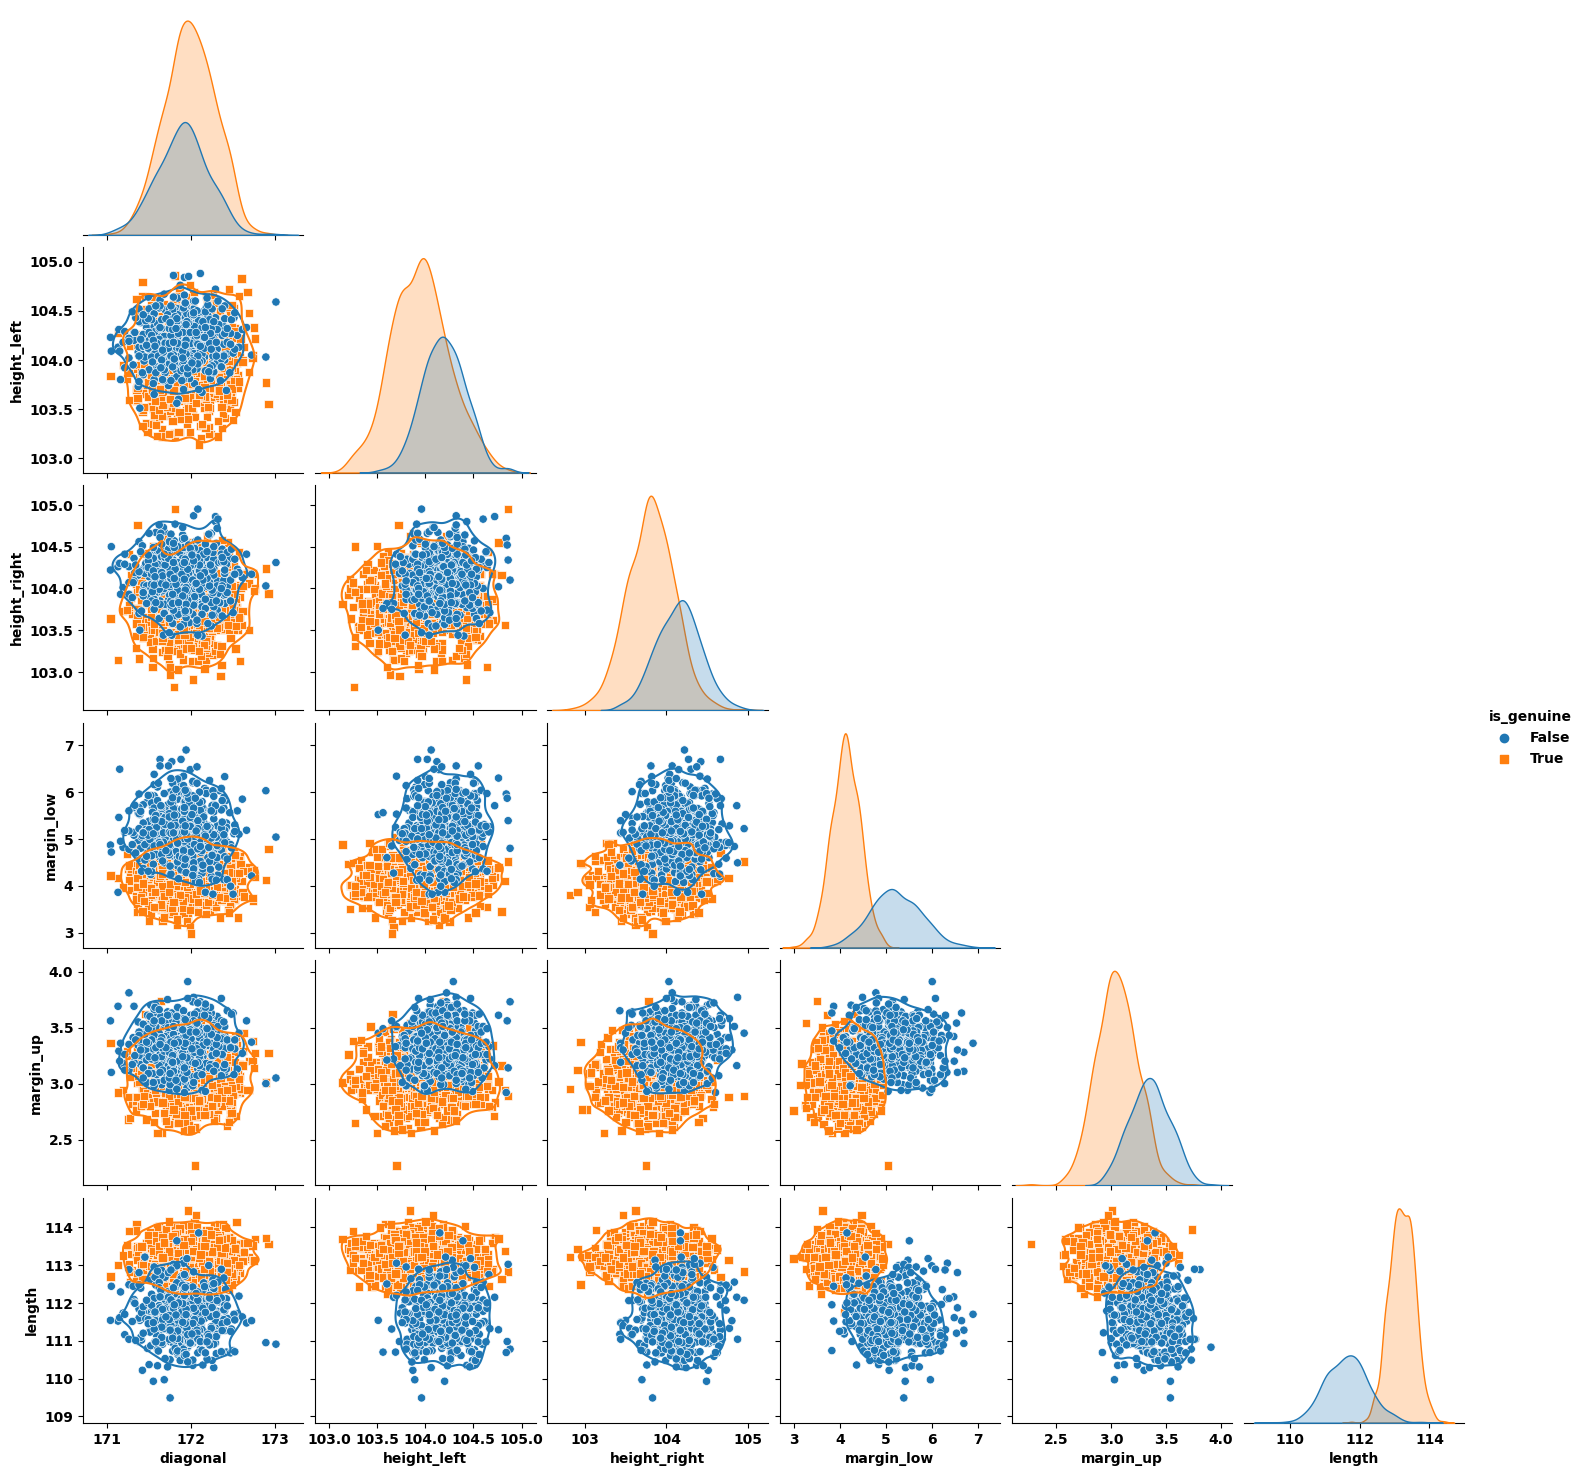

In [14]:
g = sns.pairplot(df_billet, hue='is_genuine', markers=['o','s'], corner=True)
g.map_lower(sns.kdeplot, levels=2, color='.2')

plt.show()

Fort impact de margin low et length, les autres ont peu d'impact

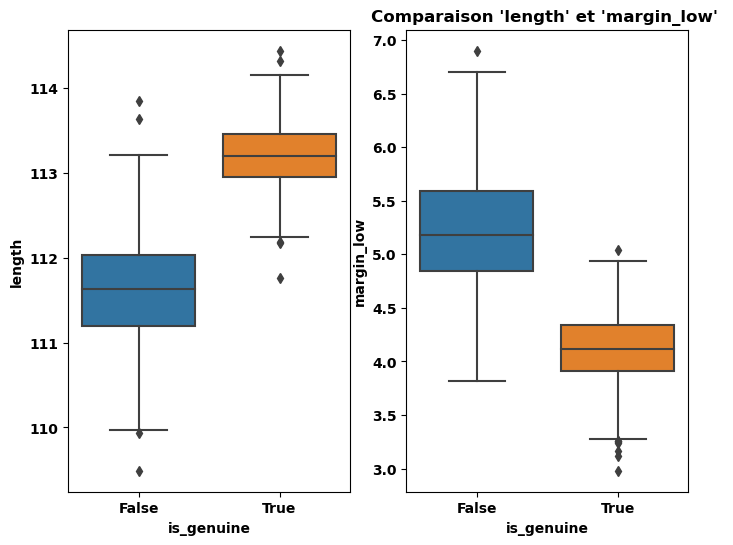

In [15]:
fig, ax = plt.subplots(1,2, figsize=(8,6))

sns.boxplot(data=df_billet, y='length', x='is_genuine', ax=ax[0])
sns.boxplot(data=df_billet, y='margin_low', x='is_genuine', ax=ax[1])
plt.title("Comparaison 'length' et 'margin_low' ")
plt.show()

La matrice des corrélations résume les dépendances entre variables par une valeur entre -1 et 1 :

0 : absence de corrélation
1 : corrélation positive
-1 : corrélation négative
Elle confirme l'impact de la longueur et de la marge basse sur l'authenticité (plus de 0.8 d'écart à 0). On dit donc que la véracité du billet est corrélée positivement à la longueur, et négativement à la marge basse. Les variables ont toutes des dépendances plus ou moins marquées avec les autres, à part dans une moindre mesure la diagonale.

In [16]:
df_billet.groupby(by='is_genuine').mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90116,104.19034,104.14362,5.214079,3.35016,111.63064
True,171.98708,103.94913,103.80865,4.118174,3.05213,113.20243


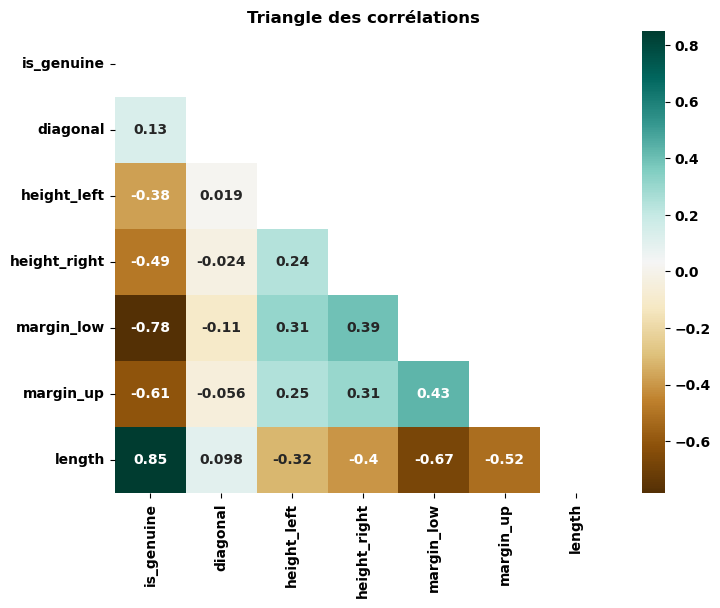

In [17]:
matrix = df_billet.corr()
mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.title('Triangle des corrélations')
plt.show()

## 2 - ACP
Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :

 - analyse de l'éboulis des valeurs propres ;
 - représentation des variables par le cercle des corrélations ;
 - représentation des individus par les plans factoriels ;
 - analyser de la qualité de représentation et la contribution des individus.
 
 L'analyse en composantes principales va nous permettre de réduire nos 6 variables quantitatives à 2. On pourra alors représenter chaque billet dans un espace à 2 dimensions. Ce qui permettra de vérifier où se situent les vrais et faux billets dans l'espace, et s'ils forment des clusters distincts. L'ACP étant sensible à la variance, on va d'abord standardiser les variables quantitatives.<br>

Standardisation des variables : <br>
Même si toutes les variables s'expriment en millimètres, leur échelle varie. Ici les marges avoisinnent 4mm alors que les longueurs dépassent 170mm. Pour que les valeurs comme celles de la longueur n'aient pas trop de poids face aux autres, il faut que toutes nos variables s'expriment dans la même unité.<br><br>

Standardiser les variables consiste à les centrer autour de 0, puis réduire à 1 leur écart type (standard deviation en anglais, d'où le terme standardisation). Le centrage ne change pas la forme d'une distribution, il ne fait que la déplacer.<br><br>

Pour que la moyenne de chaque variable soit égale à 0, on soustrait à toutes les observations la moyenne de la variable concernée.

In [18]:
df_billet.set_index('is_genuine',inplace=True, )

In [19]:
df_billet.head(n=2)

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83
True,171.46,103.36,103.66,3.77,2.99,113.09


In [20]:
# import de l'échantillon
data = df_billet[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]

# selection des colonnes à prendre en compte dans l'ACP
data_pca = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]

data.info

<bound method DataFrame.info of             diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
True          171.81       104.86        104.95        4.52       2.89  112.83
True          171.46       103.36        103.66        3.77       2.99  113.09
True          172.69       104.48        103.50        4.40       2.94  113.16
True          171.36       103.91        103.94        3.62       3.01  113.51
True          171.73       104.28        103.46        4.04       3.48  112.54
...              ...          ...           ...         ...        ...     ...
False         171.75       104.38        104.17        4.42       3.09  111.28
False         172.19       104.63        104.44        5.27       3.37  110.97
False         171.80       104.01        104.12        5.51       3.36  111.95
False         172.06       104.28        104.06        5.17       3.46  112.25
False         171.47

In [21]:
# préparation des données pour l'ACP
X = data_pca.values
names = data.index #intitulé des lignes
features = data.columns #intitulé des colonnes

In [22]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_scaled

array([[-0.48653957,  2.77412327,  3.16324041,  0.0553898 , -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08198744, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12659056, -0.91256208,
         0.55190114],
       ...,
       [-0.51931643, -0.06524991,  0.61346228,  1.55672775,  0.89984645,
        -0.83501554],
       [ 0.3328817 ,  0.83666863,  0.42914097,  1.04111674,  1.33137229,
        -0.4911519 ],
       [-1.6009525 ,  0.40241156, -0.30814427,  0.22220513,  0.94299904,
        -0.69747008]])

In [23]:
X_std = pd.DataFrame(X_scaled, columns=features) # Valeurs standardisées

In [24]:
X_std

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.055390,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.081987,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.126591,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.309463,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.672532,1.417677,-0.158750
...,...,...,...,...,...,...
1495,-0.683201,1.170713,0.767063,-0.096260,-0.265273,-1.602978
1496,0.758981,2.005822,1.596509,1.192767,0.942999,-1.958303
1497,-0.519316,-0.065250,0.613462,1.556728,0.899846,-0.835016
1498,0.332882,0.836669,0.429141,1.041117,1.331372,-0.491152


In [25]:
X_std.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03
mean,-7.850550e-14,4.812743e-14,-2.783433e-14,7.200166e-16,-9.852859e-16,4.547474e-16
std,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00
min,-3.010357e+00,-2.971432e+00,-3.380166e+00,-2.280025e+00,-3.803785e+00,-3.654697e+00
25%,-6.832007e-01,-6.999333e-01,-6.460667e-01,-7.028617e-01,-6.967992e-01,-7.433186e-01
50%,5.113189e-03,3.496326e-02,-9.420867e-04,-2.630758e-01,-4.951040e-02,3.226587e-01
75%,6.934271e-01,6.696467e-01,7.056229e-01,5.861658e-01,6.840835e-01,7.582193e-01
max,3.446683e+00,2.840932e+00,3.163240e+00,3.664667e+00,3.273239e+00,2.019053e+00


Ecart type proche de 1 ! 

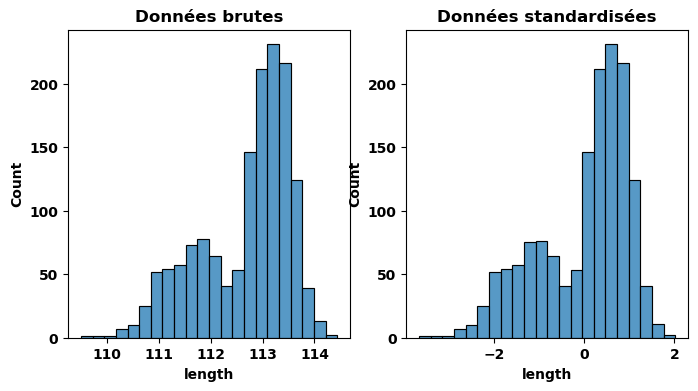

In [26]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.histplot(df_billet['length'], ax=ax[0])
sns.histplot(X_std['length'], ax=ax[1])
ax[0].title.set_text('Données brutes')
ax[1].title.set_text('Données standardisées')
plt.show()

In [27]:
# choix du nombre de composantes à calculer
n_comp = 2

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=2)

In [28]:
print(
    'Variance expliquée :', 
    round(sum(pca.explained_variance_ratio_) * 100, 1), '%',
    '\nVariance par composante :', pca.explained_variance_ratio_)

Variance expliquée : 60.2 % 
Variance par composante : [0.43288253 0.16956616]


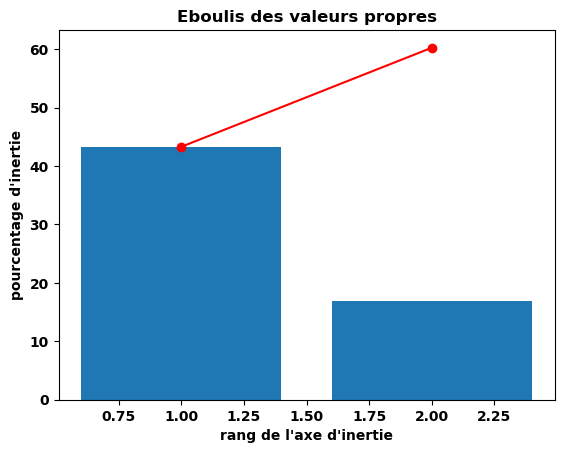

In [29]:
# Eboulis des valeurs propres
display_scree_plot(pca)

In [30]:
pca = decomposition.PCA(n_components=n_comp)
reduced = pca.fit_transform(X_std)

for i in range(0, n_comp): 
    df_billet['PC' + str(i + 1)] = reduced[:, i]
    
df_billet

,diagonal,height_left,height_right,margin_low,margin_up,length,PC1,PC2
is_genuine,,,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83,1.644135,0.747843
True,171.46,103.36,103.66,3.77,2.99,113.09,-2.019910,-2.207492
True,172.69,104.48,103.50,4.40,2.94,113.16,-0.969864,2.620492
True,171.36,103.91,103.94,3.62,3.01,113.51,-1.377462,-1.818370
True,171.73,104.28,103.46,4.04,3.48,112.54,0.148712,-0.566722
...,...,...,...,...,...,...,...,...
False,171.75,104.38,104.17,4.42,3.09,111.28,1.426243,-0.269650
False,172.19,104.63,104.44,5.27,3.37,110.97,3.279280,1.317912
False,171.80,104.01,104.12,5.51,3.36,111.95,1.889684,-0.600282


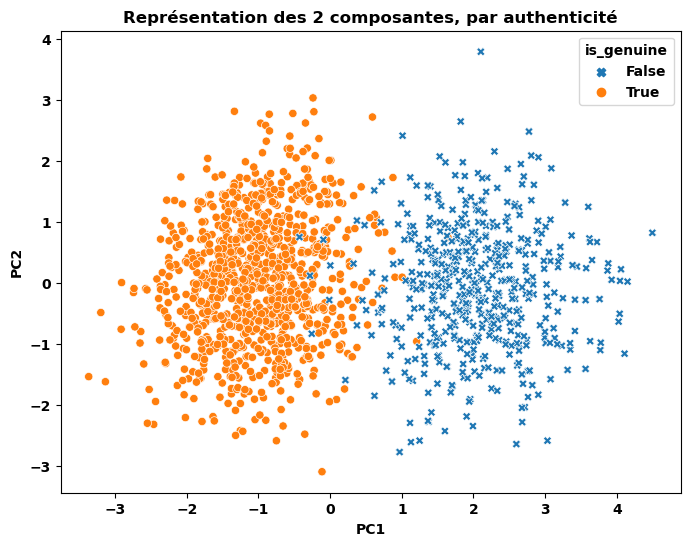

In [31]:
plt.figure(figsize=(8, 6))
scatter_markers = ['X','o']
sns.scatterplot(data=df_billet, x='PC1', y='PC2', style='is_genuine', hue='is_genuine', markers=scatter_markers,)
plt.title('Représentation des 2 composantes, par authenticité')
plt.show()

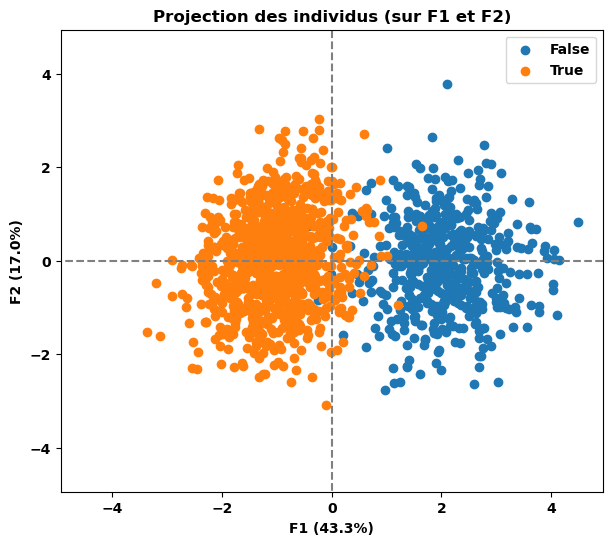

In [32]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=np.array(names))
plt.show()

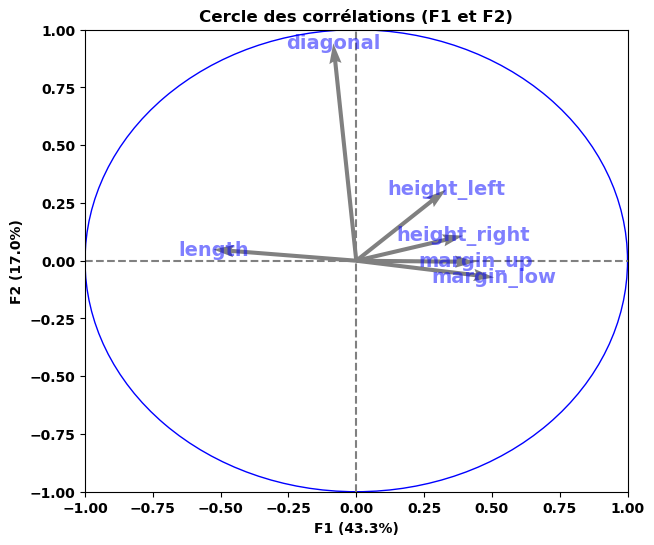

In [33]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))


Le cercle des corrélations confirme que les dépendances entre variables ont bien été conservées après projection. Pour chaque variable, la longueur de la flèche est proportionnelle à la quantité d'informations stockée par les composantes.<br><br>

La corrélation entre 2 variables se déduit par l'angle que forme leurs flèches :<br><br>

0° : corrélation positive<br>
90° : absence de corrélation<br>
180° : corrélation négative<br><br>
Les corrélations entre les 6 variables de départ ont bien été conservées après réduction en 2 dimensions. Ici, les hauteurs gauche et droite sont bien corrélées positivement, tout comme les 2 marges.<br> L'ACP a conservé suffisamment de données pour que la représentation sur le plan factoriel soit fiable.

La variable diagonal contribue fortement (et négativement) à l'axe 2

Les variables height_left et height_right contribuent le plus et positivement à l'axe 1.

Les variables margin_up et margin_low contribuent positivement à l'axe 1.

La variable lenght contribue négativement à l'axe 1.

In [34]:
#Transposition du DataFrame:
df_pcs = pd.DataFrame(pcs)
#On renommes les colonnes et les lignes pour plus de compréhension.
#Nom de colonne (Renommage)
df_pcs.columns = features
#Nom des indexs (Renommage)
x_list = range(1, n_comp+1)
df_pcs.index = [f"F{i}" for i in x_list]
#Arrondi à 2 chiffres après la virgule
df_pcs.round(2)


,diagonal,height_left,height_right,margin_low,margin_up,length
F1,-0.08,0.33,0.39,0.51,0.44,-0.53
F2,0.94,0.31,0.11,-0.07,-0.00,0.05


<Axes: >

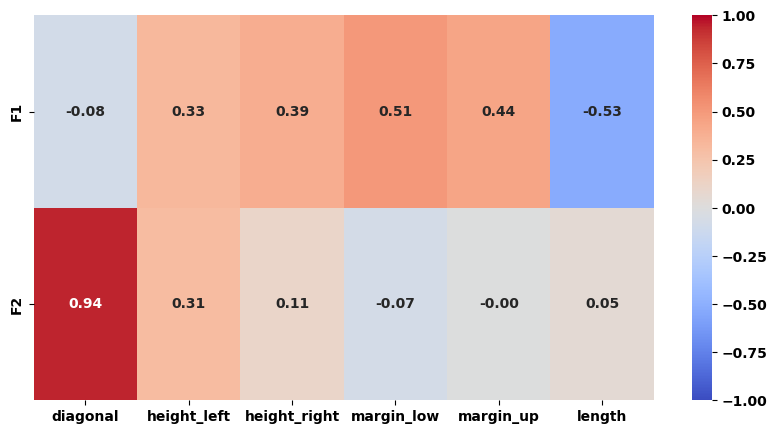

In [35]:
#Initialisation du heatmap
fig, ax = plt.subplots(figsize=(10, 5))
#On fixe un seuil à -1 et 1
sns.heatmap(df_pcs, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

La variable diagonal contribue le plus et positivement à l'axe 2 (coef. de corrélation de 0.94)

Les variables height_left et height_right contribuent le plus et positivement à l'axe 1 (coef. de corrélation de, respectivement, 0.33 et 0.39). De plus, elles sont bien corrélées (r = 0.73)

La variable lenght contribue négativement à l'axe 1 (coef. de corrélation de -0.53).

Les variables lenght et margin_low sont assez bien corrélées négativement (r = -0.64).

## CLUSTERING

Text(0.5, 1.0, 'KMeans Clustering')

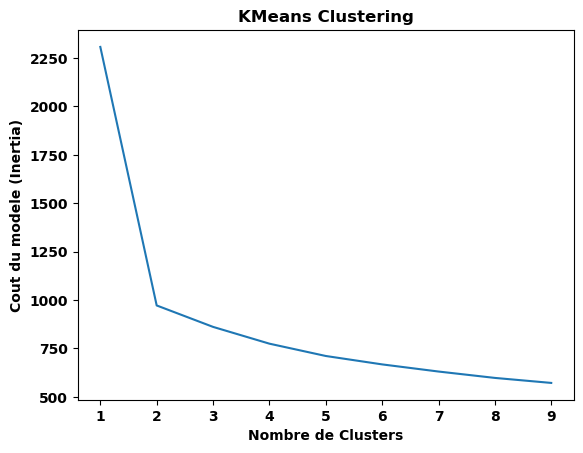

In [36]:
# MODE du coudes pour savoir combien de cluster nous avons dans notre selection de données

Inertia = []
#Nous allons de 1 à 9 clusters
K_range = range(1,10)

for k in K_range:
    model = KMeans(n_clusters = k).fit(X)
    #la valeur de l'inertie est stocker dans notre array Inertia
    Inertia.append(model.inertia_)

plt.plot(K_range, Inertia)
plt.xticks(K_range)
plt.xlabel('Nombre de Clusters')
plt.ylabel('Cout du modele (Inertia)')
plt.title('KMeans Clustering')

(1500, 6)


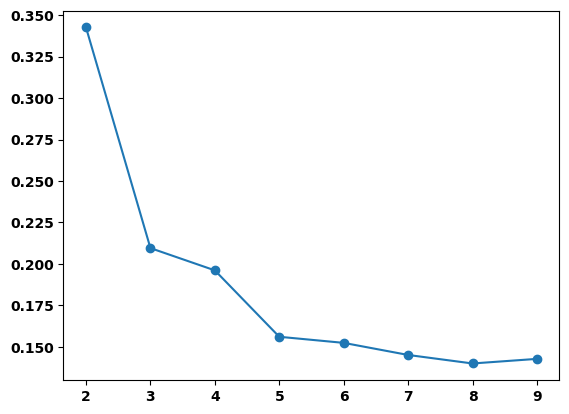

In [37]:
#Methode silhouette

#Normalisation des données pour qu'elles prennent tous la meme importance.
x_norm  = preprocessing.scale(X)
print (x_norm.shape)
silhouette = []


for num_cluster in range(2, 10):
    cls = KMeans(n_clusters = num_cluster,
                n_init = 1, init='random')
    cls.fit(x_norm)
    silh = metrics.silhouette_score(x_norm, cls.labels_)
    silhouette.append(silh)
    
plt.plot(range(2,10), silhouette, marker = 'o')

In [38]:
# Nombre de clusters souhaités
n_clust = 2

# import de l'échantillon
data =df_billet[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]

# préparation des données pour le clustering
X = data.values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# On instancie notre Kmeans avec 2 clusters : 
kmeans = KMeans(n_clusters=n_clust)
# On l'entraine notre jeux de données dans Kmeans initialiser avec 2 clusters : 
kmeans.fit(X)
# Récupération des clusters attribués à chaque individu
clusters = kmeans.labels_

In [39]:
df_billet['cluster'] = kmeans.predict(X)
#dicto = {0: 1, 1: 0} # Inversion des 0 et des 1
#df_billet['cluster'] = df_billet['cluster'].map(dicto) # Pour que 0 soit égal à False
df_billet

,diagonal,height_left,height_right,margin_low,margin_up,length,PC1,PC2,cluster
is_genuine,,,,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83,1.644135,0.747843,1
True,171.46,103.36,103.66,3.77,2.99,113.09,-2.019910,-2.207492,1
True,172.69,104.48,103.50,4.40,2.94,113.16,-0.969864,2.620492,1
True,171.36,103.91,103.94,3.62,3.01,113.51,-1.377462,-1.818370,1
True,171.73,104.28,103.46,4.04,3.48,112.54,0.148712,-0.566722,1
...,...,...,...,...,...,...,...,...,...
False,171.75,104.38,104.17,4.42,3.09,111.28,1.426243,-0.269650,0
False,172.19,104.63,104.44,5.27,3.37,110.97,3.279280,1.317912,0
False,171.80,104.01,104.12,5.51,3.36,111.95,1.889684,-0.600282,0


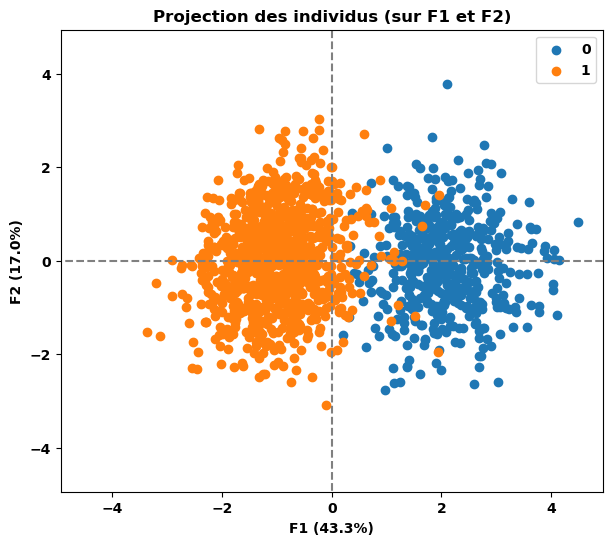

In [40]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],  illustrative_var= np.array(clusters))

plt.show()

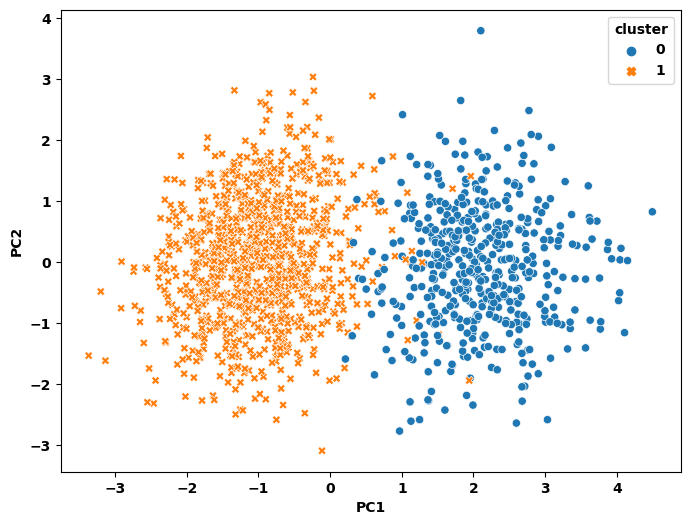

In [41]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_billet, x='PC1', y='PC2', hue='cluster', style='cluster')
plt.show()

In [98]:
plt.figure(figsize=(8,8)
sns.scatterplot(data=df_billet, x='PC1', y='PC2', markers=scatter_markers, style='is_genuine', hue='is_genuine', s=200)
sns.scatterplot(data=df_billet, x='PC1', y='PC2', markers=scatter_markers, style='cluster', hue='cluster', s=50)
plt.show() # Contour = classe réelle ; Point = cluster

SyntaxError: invalid syntax (2997578550.py, line 2)

In [43]:
pd.crosstab(clusters,df_billet.index)

col_0,False,True
row_0,,
0,481,3
1,19,997


In [44]:
df_valid = pd.crosstab(clusters,df_billet.index)
df_valid.index = ['Faux_c','Vrai_c']
df_valid.columns = ['Faux','Vrai']
df_valid

,Faux,Vrai
Faux_c,481,3
Vrai_c,19,997


### REGRESSION LOGISTIQUE

In [45]:
df_billet= df_billet.reset_index()

In [46]:
X = df_billet.drop(['is_genuine','PC1', 'PC2', 'cluster'], axis=1).values
y = df_billet['is_genuine']

In [47]:
#Initialisation de la regression Logistique
logistic = LogisticRegression()
#On entraine notre jeux de données dans la regression 
logistic.fit(X,y)

LogisticRegression()

In [48]:
probabilites = logistic.predict_proba(X)
print(probabilites) #1ère colonne proba que ce soit faux, 2ème colonne vrai

[[5.87766518e-01 4.12233482e-01]
 [2.95677288e-04 9.99704323e-01]
 [1.03557191e-02 9.89644281e-01]
 ...
 [9.97459113e-01 2.54088706e-03]
 [9.86237820e-01 1.37621796e-02]
 [8.68564775e-01 1.31435225e-01]]


In [49]:
logistic.predict(X)

array([False,  True,  True, ..., False, False, False])

In [50]:
pd.DataFrame(
    probabilites).rename(
    columns={0: 'False', 1: 'True'}).head(10)

,False,True
0,0.587767,0.412233
1,0.000296,0.999704
2,0.010356,0.989644
3,0.000148,0.999852
4,0.101361,0.898639
5,0.039020,0.960980
6,0.217653,0.782347
7,0.002499,0.997501
8,0.012944,0.987056
9,0.003738,0.996262


In [51]:
#Insertion d'une nouvelle colonne avec les valeurs de predict(X) (True or False)
df_billet['prediction']=logistic.predict(X)

In [52]:
df_validation = pd.crosstab(df_billet['is_genuine'],df_billet['prediction'])
df_validation.index = ['Falsifié','Authentique']
df_validation.columns = ['Prédiction - Faux','Prédiction - Vrai']
df_validation

,Prédiction - Faux,Prédiction - Vrai
Falsifié,490,10
Authentique,6,994


In [53]:
#taux d'erreur 
(16/1500)

0.010666666666666666

In [54]:
accuracy_score(df_billet['is_genuine'],df_billet['prediction'])

0.9893333333333333

In [55]:
df_billet

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,PC1,PC2,cluster,prediction
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1.644135,0.747843,1,False
1,True,171.46,103.36,103.66,3.77,2.99,113.09,-2.019910,-2.207492,1,True
2,True,172.69,104.48,103.50,4.40,2.94,113.16,-0.969864,2.620492,1,True
3,True,171.36,103.91,103.94,3.62,3.01,113.51,-1.377462,-1.818370,1,True
4,True,171.73,104.28,103.46,4.04,3.48,112.54,0.148712,-0.566722,1,True
...,...,...,...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,1.426243,-0.269650,0,False
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,3.279280,1.317912,0,False
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,1.889684,-0.600282,0,False
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,1.789783,0.511230,0,False


In [56]:
X = df_billet.drop(['is_genuine','PC1','PC2','cluster','prediction'], axis=1).values
y = df_billet['is_genuine']

In [57]:
#Division du jeu de donnée 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=2)

In [58]:
#Création d'une variable rl pour notre regression logisque
rl = LogisticRegression( C=0.1)
#On entrain notre train dans cette regression logisque
rl.fit(X_train, y_train)
#Creation de la variable y_pred pour stocker la prediction de X_test
y_pred = rl.predict(X_test)

In [59]:
#Test de precision.
print("Accuracy", metrics.accuracy_score(y_test, y_pred))

Accuracy 0.99


In [60]:
estimator = LogisticRegression()
selector = RFE(estimator, step=1)
selector = selector.fit(X_train, y_train)
selector.support_ 

array([False, False, False,  True,  True,  True])

In [61]:
selector.predict(X_test)

array([ True, False, False,  True,  True,  True, False,  True,  True,
       False, False,  True, False,  True,  True,  True, False,  True,
       False,  True,  True, False,  True, False, False,  True, False,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True,  True, False,  True,  True,
       False,  True, False, False,  True, False,  True, False, False,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False, False, False,  True,
       False,  True, False,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False, False,  True, False, False,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,

In [62]:
pd.crosstab(selector.predict(X_test),y_test)

is_genuine,False,True
row_0,,
False,100,1
True,2,197


In [63]:
print("Accuracy", metrics.accuracy_score(selector.predict(X_test),y_test))

Accuracy 0.99


In [64]:
train_dict = {}
train_dict[0] = std_scale
train_dict[1] = selector
train_dict[2] = pca

In [65]:
import pickle
pickle.dump(train_dict, open('train.p', 'wb'))

## 4 - TEST DU PROGRAMME

In [66]:
example=pd.read_csv("billets_production.csv", delimiter = ",")

In [67]:
example

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [68]:
train_dict = pickle.load(open('train.p', 'rb'))
std_scale = train_dict[0]
regression = train_dict[1]
pca = train_dict[2]

In [69]:
#On sotck les valeur de notre exemple en enlevant l'id du billet dans la variable X
X = example.drop(['id'], axis=1).values

In [70]:
#On stock la variable de prédiction dans valeur de notre exemple
probabilites = regression.predict(X)

In [71]:
probabilites

array([False, False, False,  True,  True])

In [72]:
print(pd.DataFrame({'ID':example['id'],'Nature':probabilites}))

    ID  Nature
0  A_1   False
1  A_2   False
2  A_3   False
3  A_4    True
4  A_5    True


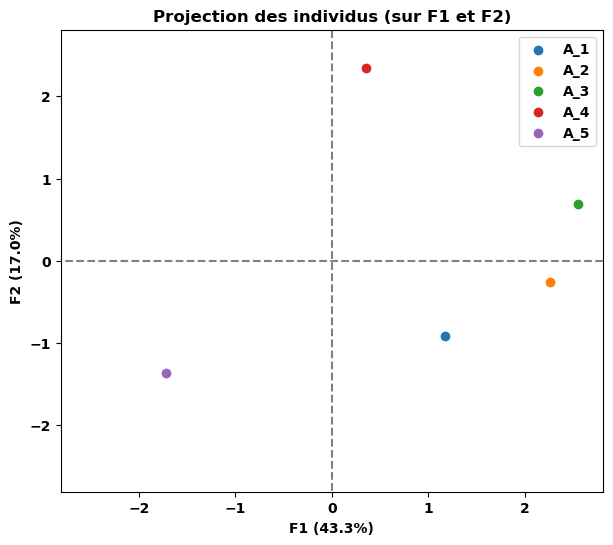

In [73]:
X_scaled = std_scale.transform(X)
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=example['id'])

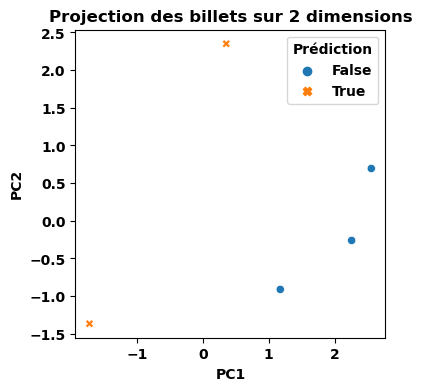

,Prédiction,Proba de faux,Proba de vrai,id
0,False,0.999145,0.000855,A_1
1,False,0.999250,0.000750,A_2
2,False,0.997223,0.002777,A_3
3,True,0.013657,0.986343,A_4
4,True,0.000973,0.999027,A_5


In [74]:
def detection(billet_csv):
    train_dict = pickle.load(open('train.p', 'rb'))
    std_scale = train_dict[0]
    regression = train_dict[1]
    pca = train_dict[2]
    
    df_billets = pd.read_csv(billet_csv, delimiter = ",") # en cas de modif du fichier, ajouter sep='\t')
    X_csv = df_billets.drop(['id'], axis=1)    
    #X_csv = pd.DataFrame(std_scale.transform(X_csv), columns=X_csv.columns) # CSV standardisé
    
    y_log = regression.predict(X_csv) # Prédictions

    predictions = []
    for i in range(0, len(y_log)):
        predictions.append(y_log[i])
        
    predictions = pd.concat([ # Jointure des prédictions
        pd.DataFrame([predictions]).rename(index={0: 'Prédiction'}).T,
        pd.DataFrame(regression.predict_proba(X_csv)).rename(columns={0: 'Proba de faux', 1: 'Proba de vrai'})], axis=1)
   

    predictions['id'] = df_billets['id'].unique()
    
    
    n_components = 2 # ACP
    X_csv = pd.DataFrame(std_scale.transform(X_csv), columns=X_csv.columns)
    reduced = pca.transform(X_csv)
    
    for i in range(0, n_components):
        predictions['PC' + str(i + 1)] = reduced[:, i]   
    
    
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=predictions, x='PC1', y='PC2',hue='Prédiction', style='Prédiction')
    plt.title('Projection des billets sur 2 dimensions')
    plt.show()
    
    return predictions.iloc[:,:-2]
    
detection('billets_production.csv')

###### Contribution à l'inertie total 

In [75]:
df_billet

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,PC1,PC2,cluster,prediction
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1.644135,0.747843,1,False
1,True,171.46,103.36,103.66,3.77,2.99,113.09,-2.019910,-2.207492,1,True
2,True,172.69,104.48,103.50,4.40,2.94,113.16,-0.969864,2.620492,1,True
3,True,171.36,103.91,103.94,3.62,3.01,113.51,-1.377462,-1.818370,1,True
4,True,171.73,104.28,103.46,4.04,3.48,112.54,0.148712,-0.566722,1,True
...,...,...,...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,1.426243,-0.269650,0,False
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,3.279280,1.317912,0,False
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,1.889684,-0.600282,0,False
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,1.789783,0.511230,0,False


In [76]:
sc=StandardScaler()
Z=sc.fit_transform(df_billet)
print(Z)

[[ 0.70710678 -0.48653957  2.77412327 ...  0.74142193  0.69020139
  -1.42274156]
 [ 0.70710678 -1.63372936 -2.23653528 ... -2.18853759  0.69020139
   0.70286834]
 [ 0.70710678  2.3978233   1.50475644 ...  2.59799116  0.69020139
   0.70286834]
 ...
 [-1.41421356 -0.51931643 -0.06524991 ... -0.59512771 -1.4488525
  -1.42274156]
 [-1.41421356  0.3328817   0.83666863 ...  0.50684014 -1.4488525
  -1.42274156]
 [-1.41421356 -1.6009525   0.40241156 ... -1.45866877 -1.4488525
  -1.42274156]]


In [77]:
di=np.sum(Z**2,axis=1) #Regarder la taille de Z,Di
ok=pd.DataFrame({'ID':df_billet.index,'d_i':di})#.sort_values(by='d_i',ascending=False)


In [78]:
ok.sort_values(by='d_i',ascending=False)

,ID,d_i
1277,1277,43.791970
1382,1382,36.797784
1254,1254,35.467493
1310,1310,34.543290
1029,1029,34.188363
...,...,...
290,290,2.181357
910,910,2.076785
723,723,2.072237
931,931,2.015588


In [79]:
df_billet_save.sort_index()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [80]:
df_billet_save=df_billet_save.drop(df_billet_save.index[11])

In [81]:
df_billet_save.head(n=12)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
5,True,172.17,103.74,104.08,4.42,2.95,112.81
6,True,172.34,104.18,103.85,4.58,3.26,112.81
7,True,171.88,103.76,104.08,3.98,2.92,113.08
8,True,172.47,103.92,103.67,4.00,3.25,112.85
9,True,172.47,104.07,104.02,4.04,3.25,113.45


In [82]:
from sklearn.decomposition import PCA
#Instanciation
acp=PCA(svd_solver='full')
print(acp)

PCA(svd_solver='full')


In [83]:
#calculs
coord=acp.fit_transform(df_billet)

# Ensuite nous pouvons déduire la qualité de représentation des individus sur l'axe n°k avec :

In [84]:
#nombre de variables
p=df_billet.shape[1]
#qualité de représentation des individus - COS2
cos2 = coord**2
for j in range(p):
    cos2[:,j] = cos2[:,j]/di 
print(pd.DataFrame({'id':df_billet.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}).sort_values(by='COS2_1'))

        id    COS2_1    COS2_2
965    965  0.000062  0.028643
661    661  0.000088  0.007544
980    980  0.000101  0.087947
934    934  0.000116  0.207060
320    320  0.000146  0.143632
...    ...       ...       ...
1017  1017  0.785407  0.001933
1088  1088  0.799655  0.000771
1347  1347  0.804206  0.006202
1015  1015  0.810166  0.000600
798    798  0.894135  0.002084

[1500 rows x 3 columns]


## 3 - Programme de vérification (REGRESSION LOGISTIQUE)

### Courbe de ROC

In [85]:
#Jeu de donnée

X = df_billet.drop(['is_genuine','prediction'], axis=1).values
y = df_billet['is_genuine']

In [86]:
# Division du jeu de donnée
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=2)

In [87]:
clf = LogisticRegression(penalty='l2', C=0.1)
#On entraine sur les données du train
clf.fit(X_train, y_train)
#On sort la prédiction sur les données du test
y_pred = clf.predict(X_test)

In [88]:
#Précision du modele 
print("Accuracy : ", metrics.accuracy_score(y_test, y_pred))

Accuracy :  0.9933333333333333


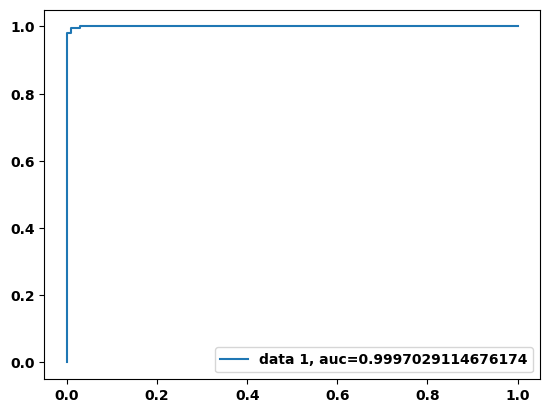

In [89]:
y_pred_proba = clf.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)



plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [90]:
estimator = LogisticRegression()
selector = RFE(estimator, step=1)
selector = selector.fit(X_train, y_train)
selector.support_ 

array([False, False, False,  True, False,  True,  True, False,  True])

In [91]:
selector.predict(X_test)

array([ True, False, False,  True,  True,  True, False,  True,  True,
       False, False,  True, False,  True,  True,  True, False,  True,
       False,  True,  True, False,  True, False, False,  True, False,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True,  True, False,  True,  True,
       False,  True, False, False,  True, False,  True, False, False,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False, False, False,  True,
       False,  True, False,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False, False,  True, False, False,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,

In [92]:
pd.crosstab(selector.predict(X_test),y_test)

is_genuine,False,True
row_0,,
False,101,1
True,1,197


In [93]:
print("Accuracy : ", metrics.accuracy_score(selector.predict(X_test),y_test))

Accuracy :  0.9933333333333333


## 4 - TEST DU PROGRAMME

In [94]:
example=pd.read_csv("billets_production.csv", delimiter = ",")

In [95]:
#Visualisation de l'exemple
example

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [96]:
#On stock les valeur de notre exemple en enlevant l'id du billet dans la variable X
X = example.drop(['id'], axis=1).values

In [97]:
#On stock la variable de prédiction dans valeur de notre exemple
probabilites = selector.predict(X)

ValueError: X has 6 features, but RFE is expecting 9 features as input.

In [ ]:
probabilites

In [ ]:
print(pd.DataFrame({'ID':example['id'],'Nature':probabilites}))

In [ ]:
X_scaled = std_scale.transform(X)
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=example['id'])